In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
file_path = "Online Retail.xlsx"
df = pd.read_excel(file_path)

In [3]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove cancelled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove invalid quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Create Sales column
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [4]:
monthly_sales = (
    df
    .set_index('InvoiceDate')
    .resample('M')['Sales']
    .sum()
)

monthly_sales.head()

C:\Users\kondu\AppData\Local\Temp\ipykernel_29524\2656894084.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['Sales']


InvoiceDate
2010-12-31    823746.140
2011-01-31    691364.560
2011-02-28    523631.890
2011-03-31    717639.360
2011-04-30    537808.621
Freq: ME, Name: Sales, dtype: float64

In [5]:
train_size = int(len(monthly_sales) * 0.8)

train = monthly_sales.iloc[:train_size]
test = monthly_sales.iloc[train_size:]

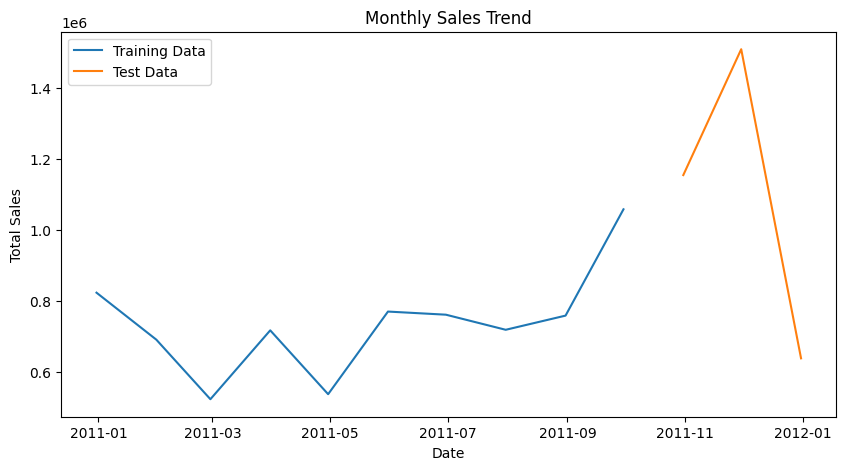

In [6]:
plt.figure(figsize=(10,5))
plt.plot(train, label="Training Data")
plt.plot(test, label="Test Data")
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.show()

In [12]:
model = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_model = model.fit()
print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   10
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -93.251
Date:                Sat, 31 Jan 2026   AIC                            192.503
Time:                        18:21:26   BIC                            192.340
Sample:                    12-31-2010   HQIC                           190.497
                         - 09-30-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5272      1.952     -0.270      0.787      -4.353       3.298
ma.L1         -0.2269      3.408     -0.067      0.947      -6.907       6.453
sigma2      2.748e+10   1.05e-10   2.62e+20      0.0

In [13]:
predictions = sarima_model.predict(
    start=test.index[0],
    end=test.index[-1],
    dynamic=False
)


In [14]:
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 378042.26
RMSE: 400787.41


In [15]:
future_steps = 6

forecast = sarima_model.get_forecast(steps=future_steps)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()


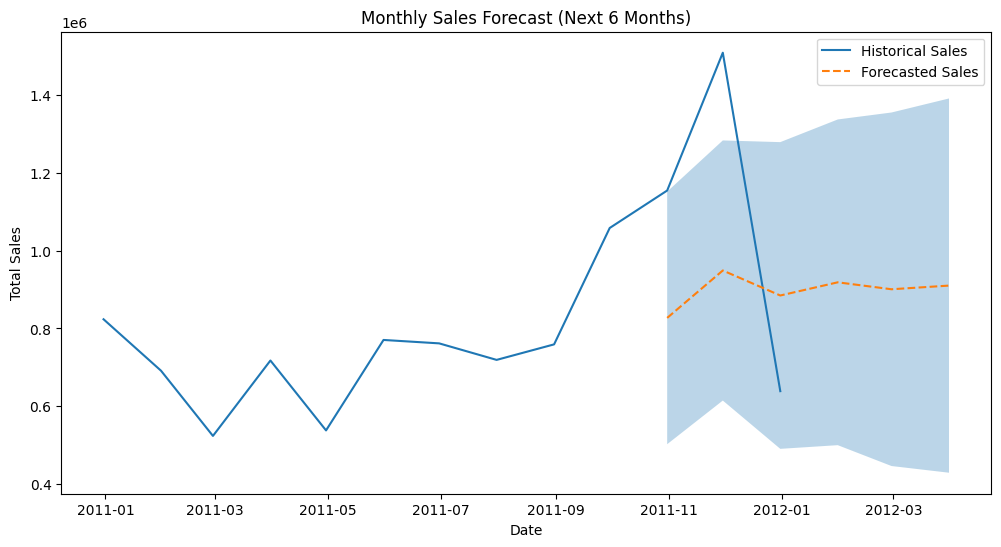

In [16]:
plt.figure(figsize=(12,6))

plt.plot(monthly_sales, label="Historical Sales")
plt.plot(forecast_values, label="Forecasted Sales", linestyle="--")

plt.fill_between(
    confidence_intervals.index,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    alpha=0.3
)

plt.title("Monthly Sales Forecast (Next 6 Months)")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.show()


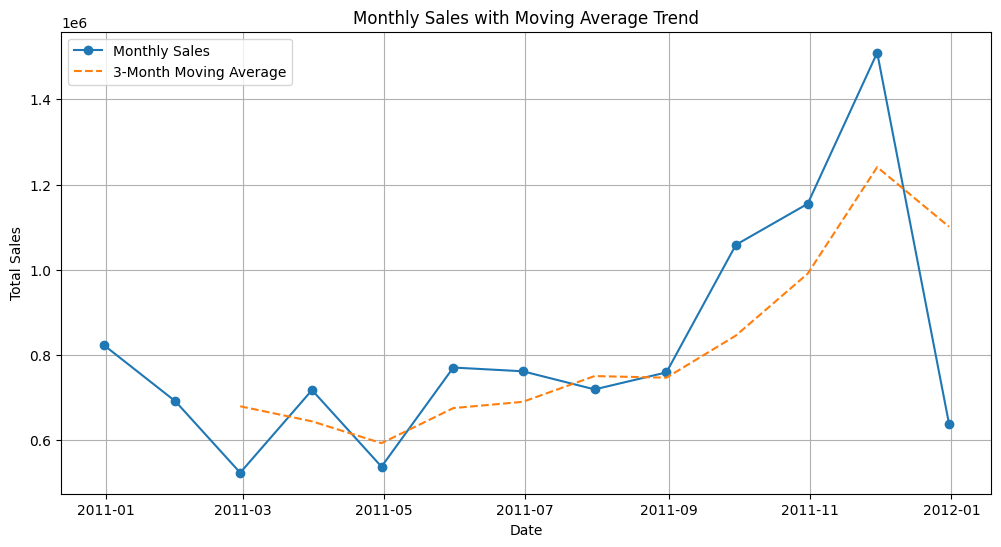

In [17]:
# Calculate 3-month moving average
moving_avg_3 = monthly_sales.rolling(window=3).mean()

# Plot original sales + moving average
plt.figure(figsize=(12,6))
plt.plot(monthly_sales, label="Monthly Sales", marker='o')
plt.plot(moving_avg_3, label="3-Month Moving Average", linestyle='--')

plt.title("Monthly Sales with Moving Average Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
forecast_table = pd.DataFrame({
    "Forecasted Sales": forecast_values.round(2),
    "Lower Confidence Interval": confidence_intervals.iloc[:, 0].round(2),
    "Upper Confidence Interval": confidence_intervals.iloc[:, 1].round(2)
})

forecast_table


,Forecasted Sales,Lower Confidence Interval,Upper Confidence Interval
2011-10-31,827257.97,502331.10,1152184.84
2011-11-30,949217.99,614615.11,1283820.88
2011-12-31,884919.78,490368.70,1279470.86
2012-01-31,918818.27,499841.62,1337794.92
2012-02-29,900946.74,446166.60,1355726.88
2012-03-31,910368.74,428943.46,1391794.01


In [19]:
# Average monthly sales
avg_monthly_sales = monthly_sales.mean()

# MAE as percentage of average sales
mae_percentage = (mae / avg_monthly_sales) * 100

print(f"Average Monthly Sales: {avg_monthly_sales:,.2f}")
print(f"MAE as % of Average Sales: {mae_percentage:.2f}%")


Average Monthly Sales: 820,514.20
MAE as % of Average Sales: 46.07%
